# Two Sigma Financial Modeling Challenge(Kaggle competition) Feature engineering

Classification of customers' interest level of apartments.

This dataset contains anonymized features pertaining to a time-varying value for a financial instrument. Each instrument has an id. Time is represented by the 'timestamp' feature and the variable to predict is 'y'. 

Importing nessesary libraries.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading data

In [4]:
import json

with open(r'C:\Users\Nadiia\Downloads\train.json\train.json') as data_file:    
    data = json.load(data_file)

Representing data as pd.DataFrame object

In [5]:
 d = pd.DataFrame(data=data)

In [6]:
d.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street


Watching basics statistics

In [39]:
d.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


Consider the target variable

In [7]:
y = d['interest_level']
y.head()

10        medium
10000        low
100004      high
100007       low
100013       low
Name: interest_level, dtype: object

Matrix of attributes.

In [8]:
X = d.drop('interest_level',1)

## Data preprocessing

### Vectorizing categorical features

In [9]:
X_categorical = d[['building_id', 'display_address','listing_id', 'manager_id', 
                   'street_address']]

To use categorical features, convert them to vectors. We can vectorize a large volumes of data with the hashing trick using sklearn.feature_extraction.text.HashingVectorizer.

In [43]:
from sklearn.feature_extraction.text import HashingVectorizer as HV

In [44]:
vectorizer= HV(n_features=len(set(d.building_id)))
building_id_vect = vectorizer.transform(list(d.building_id))

In [45]:
vectorizer= HV(n_features=len(set(d.display_address)))
display_address_vect = vectorizer.transform(list(d.display_address))

In [46]:
vectorizer= HV(n_features=len(set(d.manager_id)))
manager_id_vect = vectorizer.transform(list(d.manager_id))

In [47]:
vectorizer= HV(n_features=len(set(d.street_address)))
street_address_vect = vectorizer.transform(list(d.street_address))

Reducing quantity of features to avoid the curse of dimensionality.

In [48]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=100)
building_id_pca = tsvd.fit_transform(building_id_vect)
display_address_pca = tsvd.fit_transform(display_address_vect)
manager_id_pca = tsvd.fit_transform(manager_id_vect)
street_address_pca = tsvd.fit_transform(street_address_vect)

Each apartment have different listing_id, so we don't need to vectorize it.

In [49]:
len(set(d.listing_id))==len(d)

True

But values of d.listing_id are really big. We need reduce them to avoid too big weights in classification model. 

In [50]:
min(d.listing_id), max(d.listing_id)

(6811957, 7753784)

In [51]:
listing_id_reduced = d.listing_id - min(d.listing_id)

### One-hot encoding of categorical list of lists d.features

For transform d.features into binary matrix we need vectorizer for list of lists of categorical features. The result will be the matrix with a few ones in a row instead of one in a row. Quantity of ones will be equal to quantity of elements in each element of d.features.

In [52]:
import itertools

def list_encoder(X):
    unique_features = list(set(itertools.chain.from_iterable(X)))
    a = np.zeros(shape=(len(X),len(unique_features)))
    for s in np.arange(len(X)):
        if (len(X[s])>0):
            for col in X[s]:
                for i,u in enumerate(unique_features):
                    if ((u == col)and(a[s][i]<>1)): 
                        a[s][i]=1
        else:
            continue
    return a

In [53]:
features_oh = list_encoder(d.features)
features_oh.shape

(49352L, 1556L)

Let's check if sum of ones in each row equal to the lenght of corresponding element in d.features. 

In [54]:
all([sum(features_oh[i]) == len(d.features[i]) for i in np.arange(len(d))])

True

Reducing dimentionality of resulted list.

In [55]:
features_pca = tsvd.fit_transform(features_oh)

### Translating d.created in the time format time.struct_time

In [56]:
import time
#str(d.created[0])
struct_time = [time.strptime(str(d.created[i]), "%Y-%m-%d %H:%M:%S") for i in np.arange(len(d))]

Translating d.description from text to vector form. To do this, first clear text from HTML tags.

In [57]:
from bs4 import BeautifulSoup
import re

text=[]
for i in np.arange(len(d)):
    cleantext = BeautifulSoup(d.description[i], "lxml")
    t = re.sub('w/', '', cleantext.get_text())
    text.append(t)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(text)
print matrix.shape

(49352, 41147)


Reducing the number of features by SVD.

In [59]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=100)
matrix_pca = tsvd.fit_transform(matrix)

### Extracting features from photo.

In [10]:
url = d.photos[0][0]
url

u'https://photos.renthop.com/2/7211212_1ed4542ec81621d70d1061aa833e669c.jpg'

In [14]:
from PIL import Image
import requests
import numpy as np
from StringIO import StringIO

response = requests.get(url)
img = np.array(Image.open(StringIO(response.content)))

In [50]:
img.shape

(426L, 640L, 3L)

In [43]:
X = np.reshape(img, (-1,))

In [44]:
X.shape

(817920L,)

In [49]:
from sklearn.feature_extraction.image import grid_to_graph
from sklearn import datasets, cluster

connectivity = grid_to_graph(*img.shape)

agglo = cluster.FeatureAgglomeration(connectivity=connectivity,
                                     n_clusters=32)

agglo.fit(X)
X_reduced = agglo.transform(X)


C:\Users\Nadiia\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Nadiia\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [31]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=100)
#pca.fit(im_vect)
tsvd = TruncatedSVD(n_components=100)
img_pca = tsvd.fit_transform(img)
img.shape

(817920L, 100L)

In [33]:
im_vect_pca = tsvd.fit_transform(im_vect_pca.T)
im_vect_pca.shape

(100L, 100L)

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(im_vect_pca, interpolation='nearest')
plt.show()

### Scaling of the real features.

Consider numerical features.

In [238]:
X_numerical = d[['bathrooms','bedrooms','latitude','longitude', 'price']]

Visualize pairwise projections of numerical features.

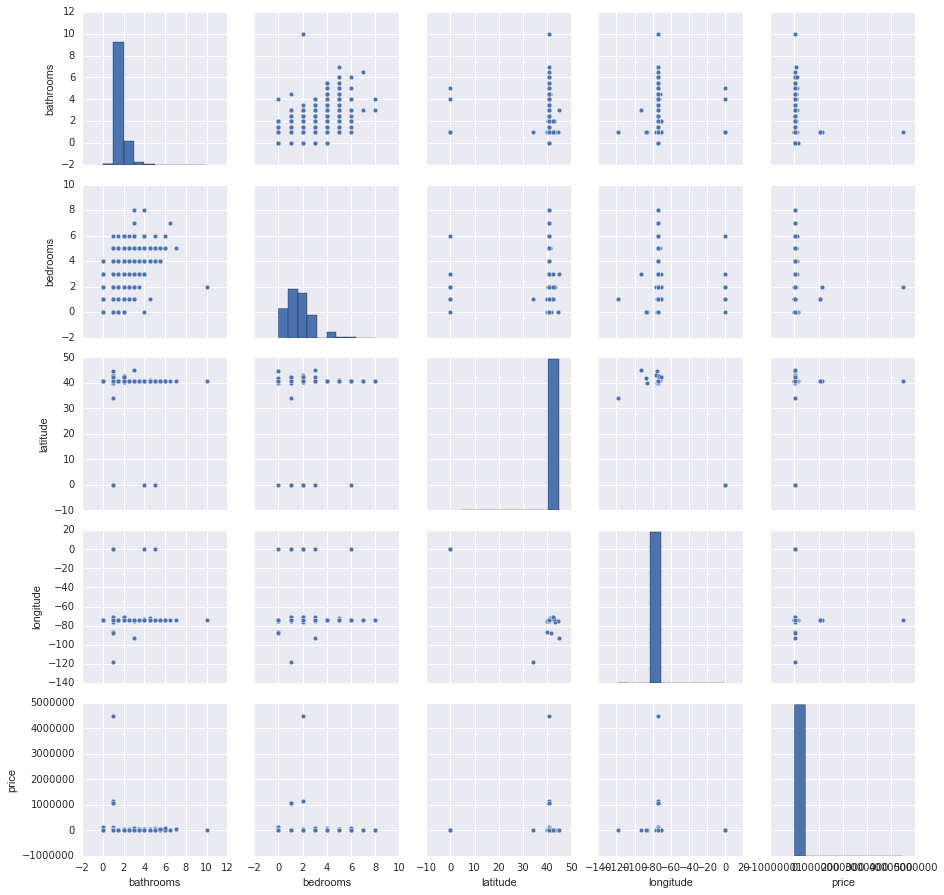

In [239]:
import seaborn as sns

sns.pairplot(X_numerical)

As we can see attributes 'price', 'longitude' and 'latitude' have a different range. We need to scale this features.

In [340]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
price_scaled = scaler.fit_transform(d.price)
latitude_scaled = scaler.fit_transform(d.latitude)
longitude_scaled = scaler.fit_transform(d.longitude)

C:\Users\Nadiia\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Nadiia\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Nadiia\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single 

In [344]:
price_scaled, latitude_scaled, longitude_scaled

(array([-0.03762122,  0.07408585, -0.04441881, ..., -0.05597472,
        -0.02176018, -0.07387504]),
 array([-0.04235489,  0.08324632, -0.00429867, ...,  0.02905926,
        -0.05472708,  0.20101703]),
 array([ 0.01121956, -0.00932548, -0.03912427, ..., -0.02910644,
        -0.04617071,  0.03269846]))

### Connect all attributes to one dataset.

In [ ]:
X_categorical = d[['building_id', 'display_address','listing_id', 'manager_id', 
                   'street_address']]

### Class balancing.

In [7]:
from collections import  Counter
Counter(y)

Counter({u'high': 3839, u'low': 34284, u'medium': 11229})

Show in the histogram levels of interest 'low', 'medium', 'high' as 1, 2, 3.

Populating the interactive namespace from numpy and matplotlib


<Container object of 3 artists>

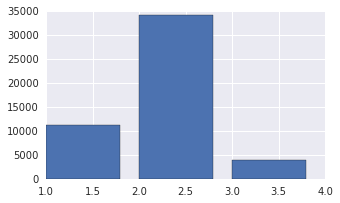

In [44]:
%pylab inline

pylab.figure(figsize = (5, 3))
pylab.bar([3,1,2], Counter(y).values())